In [1]:
import glob, json, os
from PIL import Image
from tqdm import tqdm_notebook
import numpy as np
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt

img_paths = glob.glob('./ai_challenger_caption_validation_20170910/caption_validation_images_20170910/*.jpg')
img_paths.sort()

img_paths = img_paths[:3000]
img_paths[:2]

['./ai_challenger_caption_validation_20170910/caption_validation_images_20170910\\0003a0755539c426ecfc7ed79bc74aeea6be740b.jpg',
 './ai_challenger_caption_validation_20170910/caption_validation_images_20170910\\000420107b8abee7c2f08bb21e4444a9d00c9323.jpg']

In [2]:
validation_annotations = json.load(
    open('./ai_challenger_caption_validation_20170910/caption_validation_annotations_20170910.json')
)

validation_annotations[:2]

[{'url': 'http://img5.cache.netease.com/photo/0005/2013-09-25/99LA1FC60B6P0005.jpg',
  'image_id': '3cd32bef87ed98572bac868418521852ac3f6a70.jpg',
  'caption': ['一个双臂抬起的运动员跪在绿茵茵的球场上',
   '一个抬着双臂的运动员跪在足球场上',
   '一个双手握拳的男人跪在绿茵茵的足球场上',
   '一个抬起双手的男人跪在碧绿的球场上',
   '一个双手握拳的运动员跪在平坦的运动场上']},
 {'url': 'http://img.hexun.com/2011-06-09/130363655.jpg',
  'image_id': 'fb36d921dcd9184bdd4659864fe7f3cff47accf5.jpg',
  'caption': ['房间里一个右手放在嘴角的女人和一个戴着眼镜的男人在研究仪器',
   '一个披着长发的女人和一个戴着眼镜的男人站在室内的桌子旁',
   '室内有一个戴着眼镜的男人在向一个抬起右手的女人展示东西',
   '房间里有一个左手放在盒子上的男人在给一个右手食指放在嘴边的女人展示东西',
   '一个右手放在嘴边的女人和一个戴着眼镜的男人站在房间里']}]

In [3]:
validation_annotations_dict = {x['image_id']: x['caption'][0] for x in validation_annotations}

In [4]:
img_paths_basenames = [os.path.basename(x) for x in img_paths]
img_captions = [validation_annotations_dict[x] for x in img_paths_basenames]

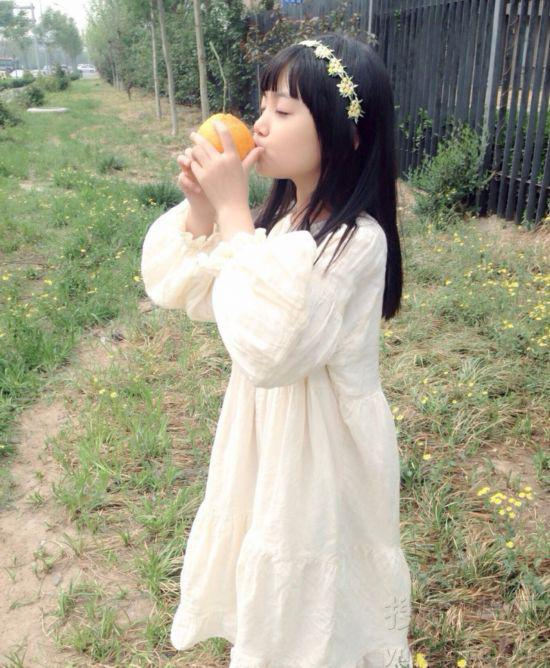

In [5]:
Image.open(img_paths[0])

In [6]:
img_captions[0]

'一个穿着裙子的女孩双手拿着东西站在宽阔的草地上'

# 加载CLIP模型

In [7]:
from PIL import Image
import requests
from transformers import ChineseCLIPProcessor, ChineseCLIPModel
import torch

model = ChineseCLIPModel.from_pretrained("./model/chinese-clip-vit-base-patch16") # 中文clip模型
processor = ChineseCLIPProcessor.from_pretrained("./model/chinese-clip-vit-base-patch16") # 预处理

HFValidationError: Repo id must be in the form 'repo_name' or 'namespace/repo_name': './model/chinese-clip-vit-base-patch16'. Use `repo_type` argument if needed.

# 图像编码

In [ ]:
img_image_feat = []

batch_size = 20
for idx in tqdm_notebook(range(len(img_captions) // batch_size + 1)):
    imgs = [ Image.open(path) for path in img_paths[idx*batch_size: (idx+1)*batch_size] ]
    
    if len(imgs) == 0:
        break
    
    inputs = processor(images=imgs, return_tensors="pt")
    with torch.no_grad():
        image_features = model.get_image_features(**inputs)
        image_features = image_features.data.numpy()
        img_image_feat.append(image_features)

    break
        
img_image_feat = np.vstack(img_image_feat)
img_image_feat = normalize(img_image_feat)

In [ ]:
img_image_feat.shape # 20张图片 512 维度

# 文本编码

In [ ]:
img_texts_feat = []

batch_size = 20
for idx in tqdm_notebook(range(len(img_captions) // batch_size + 1)):
    texts = [ text for text in img_captions[idx*batch_size: (idx+1)*batch_size] ]

    if len(texts) == 0:
        break
    
    inputs = processor(text=texts, return_tensors="pt", padding=True)

    with torch.no_grad():
        text_features = model.get_text_features(**inputs)
        text_features = text_features.data.numpy()
        img_texts_feat.append(text_features)
    break
        
img_texts_feat = np.vstack(img_texts_feat)
img_texts_feat = normalize(img_texts_feat)

In [ ]:
img_texts_feat.shape

# 尝试1：相似度计算

In [ ]:
query_idx = 250

sim_result = np.dot(img_texts_feat[query_idx], img_image_feat.T) # 矩阵计算
sim_idx = sim_result.argsort()[::-1][1:4]

In [ ]:
print('输入文本: ', img_captions[query_idx])

plt.figure(figsize=(10, 5))
plt.subplot(131)
plt.imshow(Image.open(img_paths[sim_idx[0]]))
plt.xticks([]); plt.yticks([])

plt.subplot(132)
plt.imshow(Image.open(img_paths[sim_idx[1]]))
plt.xticks([]); plt.yticks([])

plt.subplot(133)
plt.imshow(Image.open(img_paths[sim_idx[2]]))
plt.xticks([]); plt.yticks([])

In [ ]:
query_idx = 250

sim_result = np.dot(img_image_feat[query_idx], img_texts_feat.T)
sim_idx = sim_result.argsort()[::-1][1:4]

In [ ]:
plt.imshow(Image.open(img_paths[query_idx]))

print('文本识别结果: ', [img_captions[x] for x in sim_idx])

# 文本标签编码

In [ ]:
import jieba

In [ ]:
jieba.lcut('今天天气很好，心情也很好。')

In [ ]:
jieba.lcut(img_captions[0])

In [ ]:
img_captions2words = [jieba.lcut(x) for x in img_captions]
img_captions2words = sum(img_captions2words, [])

In [ ]:
img_captions2words[:10]

In [ ]:
img_captions2words = [x for x in img_captions2words if len(x) > 1]
img_captions2words = list(set(img_captions2words))

In [ ]:
img_captions2words[:10]

In [ ]:
img_texts_feat = []

batch_size = 20
for idx in tqdm_notebook(range(len(img_captions2words) // batch_size + 1)):
    texts = [ text for text in img_captions2words[idx*batch_size: (idx+1)*batch_size] ]

    if len(texts) == 0:
        break
    
    inputs = processor(text=texts, return_tensors="pt", padding=True)

    with torch.no_grad():
        text_features = model.get_text_features(**inputs)
        text_features = text_features.data.numpy()
        img_texts_feat.append(text_features)
        
img_texts_feat = np.vstack(img_texts_feat)
img_texts_feat = normalize(img_texts_feat)

# 尝试2：标签相似度计算

In [ ]:
query_idx = 120

sim_result = np.dot(img_image_feat[query_idx], img_texts_feat.T)
sim_idx = sim_result.argsort()[::-1][1:7]

In [ ]:
plt.imshow(Image.open(img_paths[query_idx]))

print('文本识别结果: ', [img_captions2words[x] for x in sim_idx])

In [ ]:
!modelscope download --model AI-ModelScope/chinese-clip-vit-base-patch16 --local_dir ./model/chinese-clip-vit-base-patch16